### 0. Questions

 - What are Decision Trees?
 - How to build a tree?
 - What is impurity criterion (quality criterion)?
     - For classification
         - Gini (Gini impurity/uncertainty)
         - Entropy (information gain)
     - For regression
 - How a decision tree works with numerical features (chooses which splits to check)?
 - What are the main parameters for Decision Tree? 
     - max_depth <!-- the maximum depth of the tree -->
     - max_features <!-- the maximum number of features with which to search for the best partition (this is necessary with a large number of features because it would be "expensive" to search for partitions for all features) -->
     - min_samples_leaf <!-- the minimum number of samples in a leaf. This parameter prevents creating trees where any leaf would have only a few members. -->
 - How to deal with overfitting in decision trees?
 <!-- artificial limitation of the depth or a minimum number of samples in the leaves: the construction of a tree just stops at some point;
pruning the tree. -->
 - In what situation trees can be built to the maximum depth?
 <!-- 
Random Forest (a group of trees) averages the responses from individual trees that are built to the maximum depth (we will talk later on why you should do this)
Pruning trees. In this approach, the tree is first constructed to the maximum depth. Then, from the bottom up, some nodes of the tree are removed by comparing the quality of the tree with and without that partition (comparison is performed using cross-validation, more on this below). -->
 - What are advantages and disadvantages of decision trees?

### 1. Import packages

First, let's import needed modules and set random seed (we'll use it if needed).

In [25]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

SEED = 42

## 2. Classification

### 2.1 Synthetic data generation

I'm going to use only two features for better visualization and analysis.  
One feature will be with the mean of the distribution around the 0.  
Second feature will be around the 2.

In [6]:
# first class
np.random.seed(SEED)
train_data = np.random.normal(size=(100, 2), loc=0)
train_labels = np.zeros(100)

In [7]:
# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Next lines will plot our dataset alongside with straight line, separating two classes.

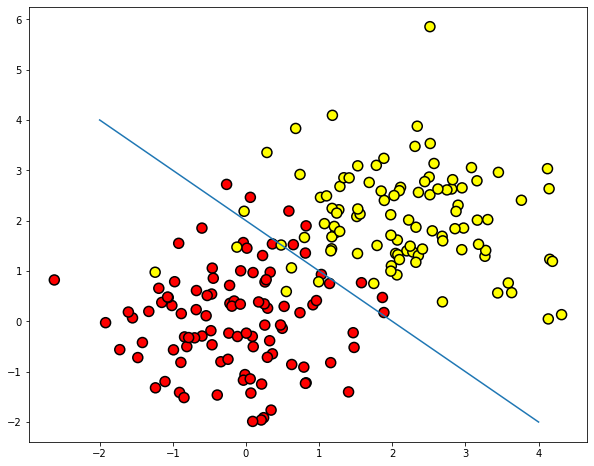

In [8]:
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.plot(range(-2, 5), range(4, -3, -1))

### 2.2 Splitting the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=SEED)

### 2.3. Predictive modeling

#### 2.3.1 Sklearn's implementation of Decision Trees Classifier

In [10]:
dt = DecisionTreeClassifier(max_depth=3, random_state=SEED, criterion='entropy')
dt.fit(X_train, y_train)
pred_sklearn = dt.predict(X_test)

f1_sklearn = f1_score(y_true=y_test, y_pred=pred_sklearn, average='weighted').round(2)
print(f'F1 is equal to {f1_sklearn}')

F1 is equal to 0.9


### 2.4. Vizualization

#### 2.4.1 Vizualization of separation boundary

In [11]:
# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

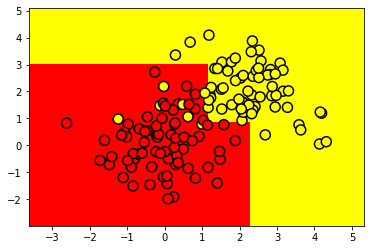

In [12]:
# some code to depict separating surface
xx, yy = get_grid(X_train)
predicted = dt.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn", shading='auto')
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5
)

#### 2.4.2 Tree vizualization

In [40]:
import pydotplus
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    """
    This requires GraphViz to be installed.  
    """
    
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [41]:
tree_graph_to_png(
    tree=dt,
    feature_names=['x1', 'x2'],
    png_file_to_save="img/decision_tree1.png",
)

In the beginning, there were 140 samples (instances), 71 ones and 69 zeros. The entropy of the initial state was maximal, `S = 1`. Then, the first partition of the samples into 2 groups was made by comparing the value of `x1` with `1.159`. With that, the entropy of both left and right groups decreased. The process continues up to depth 3. In this visualization, the more samples of the first class, the darker the orange color of the vertex; the more samples of the second class, the darker the blue. At the beginning, the number of samples from two classes is almost equal, so the root node of the tree is white.

![Decision Tree for classification task](img/decision_tree1.png)

## 3. Regression

Let's generate some data distributed by the function $f(x)=e^{−x^{2}} - 1.5 * e^{−(x−2)^{2}}$ with some noise. Then we will train a tree with this data and predictions that the tree makes.

### 3.1 Synthetic data generation

In [22]:
n_train = 150
n_test = 1000
noise = 0.1

In [35]:
def f(x):
    x = x.ravel()
    return np.exp(-(x ** 2)) - 1.5 * np.exp(-((x - 2) ** 2))


def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = (np.exp(-(X ** 2)) - 1.5 * np.exp(-((X - 2) ** 2)) + np.random.normal(0.0, noise, n_samples))
    X = X.reshape((n_samples, 1))
    return X, y

### 3.2 Splitting the data

In [36]:
X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

### 3.3. Predictive modeling

#### 3.3.1 Sklearn's implementation of Decision Trees Regressor

For the sake of better visualization let's make `max_depth` equal to `3`.

In [53]:
reg_tree = DecisionTreeRegressor(max_depth=3, random_state=SEED)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

### 3.4. Vizualization

#### 3.4.1 Visualization of regression piecewise-constant line

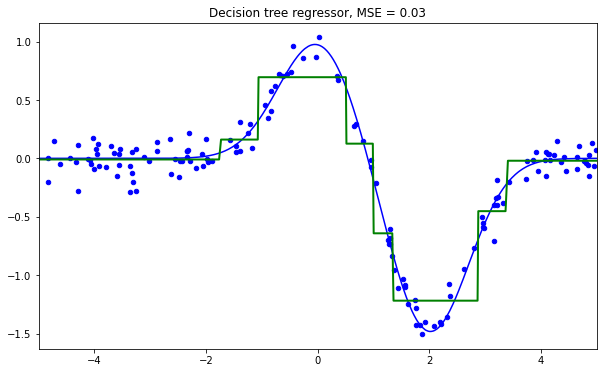

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title(f"Decision tree regressor, MSE = {(np.sum((y_test - reg_tree_pred) ** 2) / n_test).round(2)}")
plt.show()

#### 3.4.2 Tree visualization

In [55]:
tree_graph_to_png(
    tree=reg_tree,
    feature_names=['x'],
    png_file_to_save="img/decision_tree2.png",
)

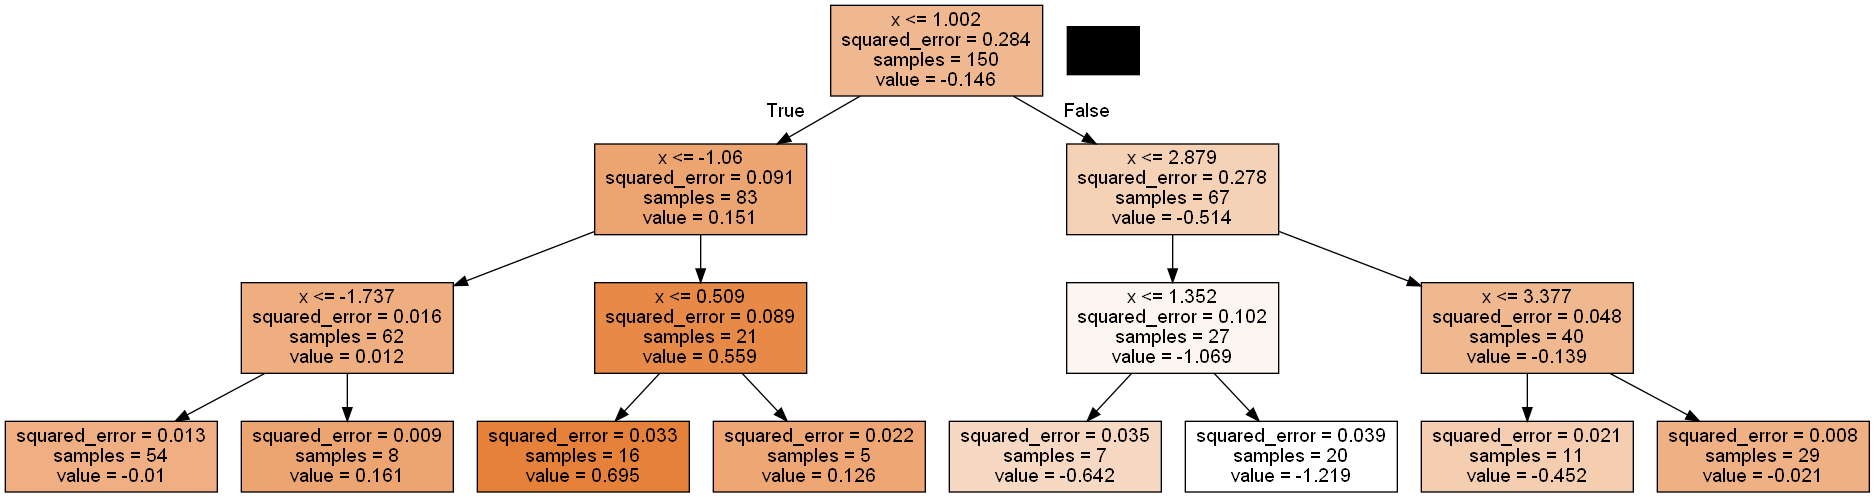

In [58]:
from IPython.core.display import Image, display
display(Image('img/decision_tree2.png', width=1875, unconfined=False))

Double tap on the picture to view it in 100% scale.

### TODO: 
 - 